# RL Assignment 3 : Problem 1 - Pong

Name : Ahmik Virani <br>
Roll Number : ES22BTECH11001

In [1]:
import gymnasium as gym
import ale_py
import cv2
import numpy as np
import pygame
import random
from collections import deque
gym.register_envs(ale_py)
from collections import deque
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio

/opt/anaconda3/envs/gympygame/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


### Q1 (a)

In [2]:
# An agent which takes random actions at each state
def run_random_agent(env, render):
    # We keep track of the reward
    total_reward = 0
    
    # A variable which keeps track of weather the episode is over or not
    done = False
    while not done:
        # Take a random action
        action = env.action_space.sample()
        next_observation, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        
        if(render):
            env.render()
        total_reward += reward
    
    # Return the reward for this episode
    return total_reward

# A function which loads the environment
# Prints the necessary points asked in the question
# And runs the random agent
def load_and_test_env(env_name, n_episodes=5, render=False):
    print(f"Loading environment: {env_name}")
    if(render):
        env = gym.make(env_name, render_mode="human")
    else:
        env = gym.make(env_name)

    state_space = env.observation_space
    action_space = env.action_space
    print()
    print("State Space: ", state_space)
    print("Size of State Space", state_space.shape[0])
    print()
    print("Action Space: ", action_space)
    print("Size of Action space: ", action_space.n)
    print()

    for episode in range(n_episodes):
        observation, info = env.reset()
        reward = run_random_agent(env, render)
        print(f"Episode #{episode+1}: reward = {reward}")

In [3]:
load_and_test_env("ALE/Pong-v5")

Loading environment: ALE/Pong-v5

State Space:  Box(0, 255, (210, 160, 3), uint8)
Size of State Space 210

Action Space:  Discrete(6)
Size of Action space:  6



A.L.E: Arcade Learning Environment (version 0.11.2+ecc1138)
[Powered by Stella]


Episode #1: reward = -20.0
Episode #2: reward = -21.0
Episode #3: reward = -20.0
Episode #4: reward = -20.0
Episode #5: reward = -20.0


## Q1 (b)

In [4]:
from collections import deque

# Implementing a FIFO replay buffer
class replay_buffer():
    # We will define the size of the replay buffer
    def __init__(self, size):

        # By size, I mean the number of samples (s, a, r, s') it can hold
        self.samples = deque(maxlen=size)
    
    def add_sample(self, sample):
        self.samples.append(sample)
    
    def pick_random(self, batch_size):
        return random.sample(self.samples, batch_size)

    def __len__(self):
        return len(self.samples)

### We will do some preprocessing

In [5]:
# First we do some image pre-processing
# This will be sent as the input to the Pong Q_phi network

def process_image(image, height=84, width=84):
    # First we conver to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Resize
    image = cv2.resize(image, (width, height), interpolation=cv2.INTER_LINEAR)

    # Also normalize to 0,1 so it is easier for neural network to train
    image = image.astype(np.float32) / 255.0

    return image

# perform image subtraction between two successive frames
def make_state(prev_image, curr_image, height=84, width=84):
    curr_image = process_image(curr_image, height, width)
    if(prev_image is None):
        return curr_image
    prev_image = process_image(prev_image, height, width)
    return (curr_image-prev_image)

In [ ]:
# Pong network

class Pong_Network(nn.Module):
    def __init__(self, input_size, num_actions, hidden_dim=256):
        # Building a convnet
        super(Pong_Network, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=4, stride=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)

        cnn_output_size = self.conv_output_size(input_size)

        self.fc1 = nn.Linear(cnn_output_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        
        self.output = nn.Linear(hidden_dim, num_actions)

        #Initialize weights
        self.apply(self.weights_init)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = torch.flatten(x, 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        
        output = self.output(x)

        return output

    # A helper function which would give the size of the output layer of the convolutions
    def conv_output_size(self, input_size, device='cpu'):
        x = torch.zeros(1, *input_size).to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        return x.view(-1).shape[0]
    
    # A helper function to initialize weigts
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
    
    def select_epsilon_greedy_action(self, state, action_space, epsilon=0.1, device='cpu'):
        # Take an epsilon greedy action
        if(np.random.rand()<epsilon):
            return action_space.sample()
        else:
            state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
            with torch.no_grad():
                q_values = self(state_tensor)
            return torch.argmax(q_values).item()

    def select_greedy_action(self, state, device='cpu'):
        # Take an  greedy action
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = self(state_tensor)
        return torch.argmax(q_values).item()

In [ ]:
env = gym.make("ALE/Pong-v5")
num_actions = env.action_space.n
input_shape = (4, 84, 84)

# Here we will print the network architecture summary
q_pong = Pong_Network(input_shape, num_actions)
q_pong = q_pong
summary(q_pong, input_size=(4, 84, 84))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 41, 41]             520
            Conv2d-2           [-1, 16, 19, 19]           2,064
            Conv2d-3             [-1, 32, 8, 8]           8,224
            Linear-4                  [-1, 256]         524,544
            Linear-5                  [-1, 256]          65,792
            Linear-6                  [-1, 256]          65,792
            Linear-7                    [-1, 6]           1,542
Total params: 668,478
Trainable params: 668,478
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.17
Params size (MB): 2.55
Estimated Total Size (MB): 2.83
----------------------------------------------------------------


In [8]:
# A helper function to plot the learning curves
# Training curves
def plot_rewards(rewards, episode_count = None, window=50, ma = False):
    plt.figure(figsize=(10,5))

    if episode_count is None:
        x_axis = np.arange(len(rewards))
    else:
        x_axis = episode_count

    plt.plot(x_axis, rewards, label='Raw Value of Rewards', alpha=0.4)
    if(ma):
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label=f'{window}-episode Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.show()

Episode 100: Avg Test Reward = -21.00, Epsilon = 0.964
Episode 200: Avg Test Reward = -21.00, Epsilon = 0.935
Episode 300: Avg Test Reward = -20.60, Epsilon = 0.906
Episode 400: Avg Test Reward = -20.20, Epsilon = 0.876
Episode 500: Avg Test Reward = -20.40, Epsilon = 0.846
Episode 600: Avg Test Reward = -20.00, Epsilon = 0.815
Episode 700: Avg Test Reward = -20.00, Epsilon = 0.783
Episode 800: Avg Test Reward = -18.20, Epsilon = 0.749
Episode 900: Avg Test Reward = -18.80, Epsilon = 0.713
Episode 1000: Avg Test Reward = -17.40, Epsilon = 0.676
Episode 1100: Avg Test Reward = -15.80, Epsilon = 0.637
Episode 1200: Avg Test Reward = -13.80, Epsilon = 0.598
Episode 1300: Avg Test Reward = -16.80, Epsilon = 0.556
Episode 1400: Avg Test Reward = -14.80, Epsilon = 0.514
Episode 1500: Avg Test Reward = -15.20, Epsilon = 0.469
Episode 1600: Avg Test Reward = -14.60, Epsilon = 0.422
Episode 1700: Avg Test Reward = -12.20, Epsilon = 0.370
Episode 1800: Avg Test Reward = -13.00, Epsilon = 0.312
E

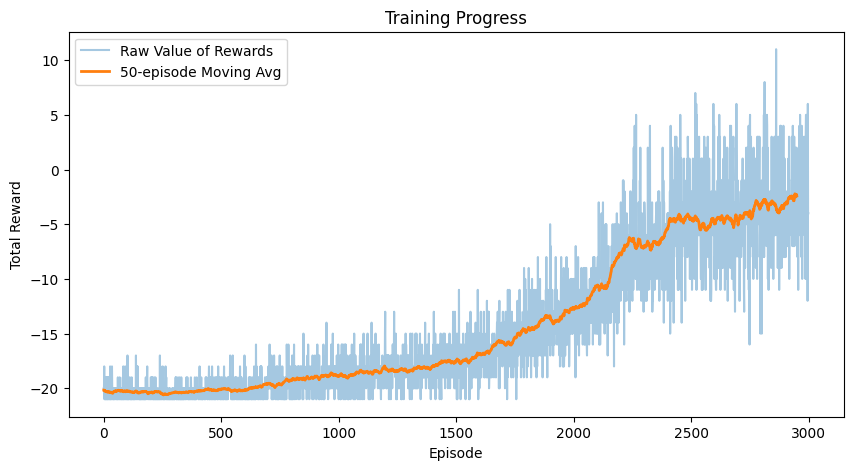

In [ ]:
env = gym.make("ALE/Pong-v5")
gamma = 0.99 
batch_size = 128
N = 500000
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

learning_rate = 2.5e-4
epsilon_start = 1.0
epsilon_end = 0.05
epsilon_decay_steps = 3000000

TAU = 0.99

# Steps in order from Lecture 13 of class notes

# 1: Intialize replay memory D to capacity N
D = replay_buffer(N)

# 2: Initialize action value function Q with parameters ϕ
Q = Pong_Network(input_shape, num_actions).to(device)

# 3: Initialize target action value function Q' with parameters ϕ′
Q_target = Pong_Network(input_shape, num_actions).to(device)

# Copy initial weights
Q_target.load_state_dict(Q.state_dict())

'''
4: for episodes = 1 to M do
5: Initialize start state s1
6: for steps t= 1 to T do
7: Select action at using ϵ-greedy policy
8: Execute action at and store transition (st,at,rt,st+1) in D
9: Sample random minibatch (size B) of transitions from D
10: for b = 1 to B do
11: Calculate targets for each transitions (Bellman backup or reward)
12: end for
13: Perform a gradient descent step on (yi-Qϕ(st,at))2 w.r.t ϕ
14: Every C steps set Q= Q
15: end for
16: end for
'''

optimizer = optim.RMSprop(Q.parameters(), lr=learning_rate, alpha=0.95, eps=0.01)

frame_stack = deque(maxlen=4)

reward_per_episode = []
test_reward_per_episode = []

# Pre fill the buffer
steps = 0
state, _ = env.reset()
processed_frame = process_image(state)

for _ in range(4):
    frame_stack.append(processed_frame)
state_stack = np.stack(frame_stack, axis=0)

for _ in range(20000):
    steps += 1
    a = env.action_space.sample()
    next_state, reward, terminated, truncated, info = env.step(a)
    done = terminated or truncated

    frame_stack.append(make_state(state, next_state))
    next_state_stack = np.stack(frame_stack, axis=0)

    D.add_sample((state_stack, a, reward, next_state_stack, done))
    if done:
        state, _ = env.reset()
        processed_frame = process_image(state)
        for _ in range(4):
            frame_stack.append(processed_frame)
        state_stack = np.stack(frame_stack, axis=0)
        
    else:
        state_stack = next_state_stack
        state = next_state

# Specify the number of episodes to be run for
M = 3000
for episodes in range(1, M+1):
    state, _ = env.reset()
    processed_frame = process_image(state)
    for _ in range(4):
        frame_stack.append(processed_frame)
    state_stack = np.stack(frame_stack, axis=0)
    done = False

    total_reward = 0
    while(not done):
        steps += 1

        # Select epsilon greedy action
        decay_ratio = steps / epsilon_decay_steps
        epsilon = epsilon_start - (epsilon_start - epsilon_end) * decay_ratio
        epsilon = max(epsilon_end, epsilon)
        a = Q.select_epsilon_greedy_action(state_stack, env.action_space, epsilon = epsilon, device=device)

        # Then we execute the action
        next_state, reward, terminated, truncated, info = env.step(a)
        done = (terminated or truncated)
        r = reward

        total_reward += r

        frame_stack.append(make_state(state, next_state))
        next_state_stack = np.stack(frame_stack, axis=0)

        # We store the transition in replay buffer
        D.add_sample((state_stack,a,r,next_state_stack, done))

        # We sample a minibatch
        if steps % 4 == 0:
            if(len(D) > batch_size):
                B = D.pick_random(batch_size)
                states = torch.tensor(np.array([t[0] for t in B], dtype=np.float32)).to(device)
                next_states = torch.tensor(np.array([t[3] for t in B], dtype=np.float32)).to(device)
                actions = torch.tensor(np.array([t[1] for t in B], dtype=np.int64)).to(device)
                rewards = torch.tensor(np.array([t[2] for t in B], dtype=np.float32)).to(device)
                dones = torch.tensor(np.array([t[4] for t in B], dtype=np.float32)).to(device)


                with torch.no_grad():
                    # 1. Use the main network to select the greedy action
                    best_actions = Q(next_states).argmax(1)
                    
                    # 2. Use the target network to get the Q value
                    q_target_next = Q_target(next_states).gather(1, best_actions.unsqueeze(1)).squeeze(1)
                    
                    # 3. Compute the Bellman target
                    q_target = rewards + gamma * q_target_next * (1 - dones)

                q_values = Q(states)
                q_s_a = q_values.gather(1, actions.unsqueeze(1)).squeeze(1)

                loss = F.smooth_l1_loss(q_s_a, q_target)
                
                # gradient descent step
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                with torch.no_grad():
                    for param, target_param in zip(Q.parameters(), Q_target.parameters()):
                        target_param.data.mul_(TAU)
                        target_param.data.add_((1-TAU) * param.data)
        
        state_stack = next_state_stack
        state = next_state

    reward_per_episode.append(total_reward)  

    # After every 100 episodes, run testing to see how it is performing
    if episodes % 100 == 0:
        test_rewards = []
        for _ in range(5):
            state, _ = env.reset()
            processed_frame = process_image(state)
            frame_stack = deque([processed_frame] * 4, maxlen=4)
            state_stack = np.stack(frame_stack, axis=0)
            done = False
            total_r = 0

            while not done:
                # Select greedy action (no exploration)
                a = Q.select_greedy_action(state_stack, device=device)

                next_state, r, terminated, truncated, _ = env.step(a)
                done = terminated or truncated
                total_r += r

                # Update frame stack and next state
                next_processed = make_state(state, next_state)
                frame_stack.append(next_processed)
                state_stack = np.stack(frame_stack, axis=0)
                state = next_state

            test_rewards.append(total_r)

        avg_test_reward = np.mean(test_rewards)
        print(f"Episode {episodes}: Avg Test Reward = {avg_test_reward:.2f}, Epsilon = {epsilon:.3f}")
        test_reward_per_episode.append(avg_test_reward)
    
plot_rewards(reward_per_episode, ma = True)

In [10]:
print("Maximum Reward: ", max(reward_per_episode))

Maximum Reward:  11.0


In [13]:
# A helper function to plot the learning curves
# Training curves
def plot_rewards(rewards, y_label, title, label, episode_count = None, window=50, ma = False):
    plt.figure(figsize=(10,5))

    if episode_count is None:
        x_axis = np.arange(len(rewards))
    else:
        x_axis = episode_count

    plt.plot(x_axis, rewards, label=label, alpha=0.4)
    if(ma):
        smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label=f'{window}-episode Moving Avg', linewidth=2)
    plt.xlabel('Episode')
    plt.ylabel(y_label)
    plt.title(title)
    plt.legend()
    plt.show()

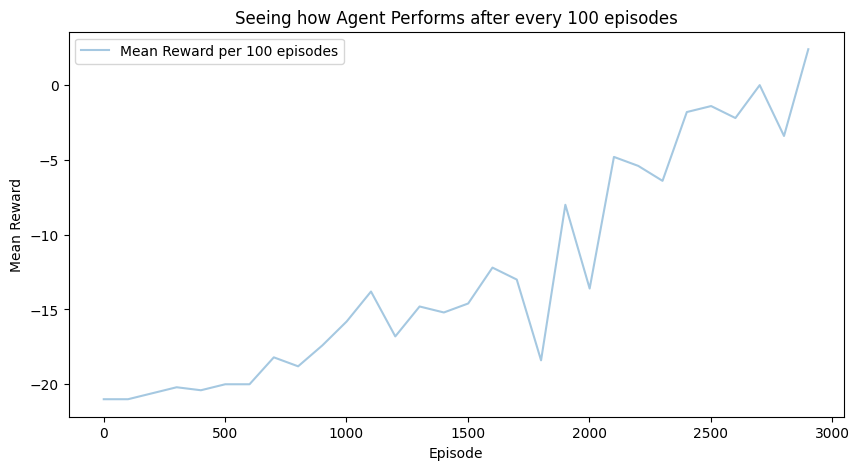

In [14]:
episodes = [i for i in range(1, M+1, 100)]
plot_rewards(test_reward_per_episode,'Mean Reward', 'Seeing how Agent Performs after every 100 episodes', 'Mean Reward per 100 episodes' , episodes)